In [76]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
from pathlib import Path
from zipfile import ZipFile
import matplotlib.pyplot as plt
import pprint
import numpy as np
import seaborn as sns 

In [178]:
# Load the CSV file into a DataFrame
df = pd.read_csv('./cleaned_merged_course_data.csv')


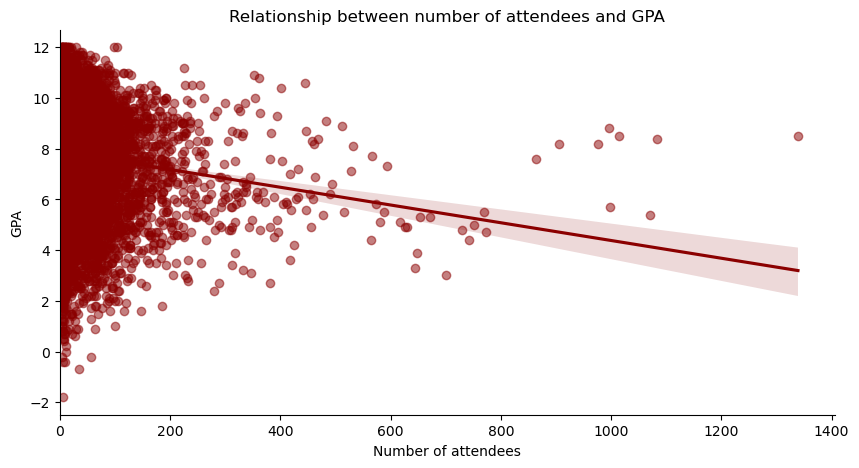

In [192]:
# Convert "Eksamensgennemsnit" to a numeric type
df = pd.read_csv('./cleaned_merged_course_data.csv')
df['Eksamensgennemsnit'] = pd.to_numeric(df['Eksamensgennemsnit'].str.replace(',', '.'), errors='coerce')

# Ensure "Fremmødte" is numeric (if it isn't already)
df['Fremmødte'] = pd.to_numeric(df['Fremmødte'], errors='coerce')

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create the regression plot with the color set to red
sns.regplot(y='Eksamensgennemsnit', x='Fremmødte', data=df, color='darkred', ax=ax, scatter_kws={'alpha':0.5})

# Set the limits to ensure (0,0) is at the intersection of the axes
ax.set_xlim(left=0)

# Set the title and axis labels
ax.set_title("Relationship between number of attendees and GPA")
ax.set_xlabel("Number of attendees")
ax.set_ylabel("GPA")


# Save and show
plt.savefig("figure1.png")
plt.show()

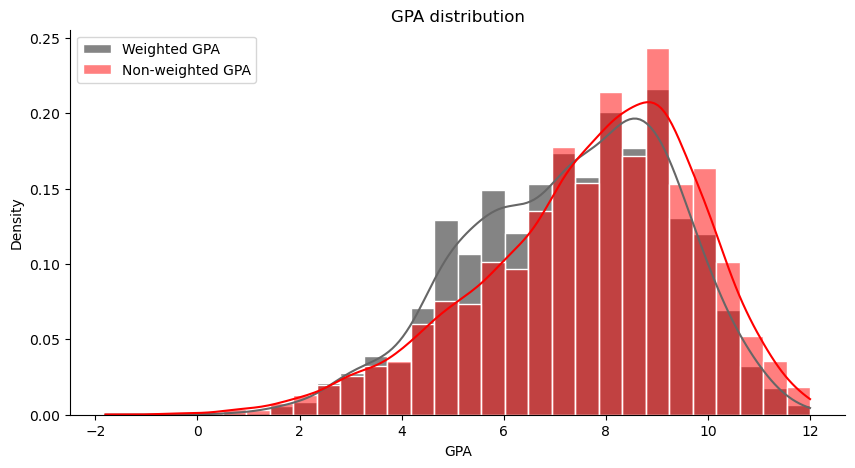

In [170]:
# Ensure 'Eksamensgennemsnit' is treated as a string first, then convert
df['Eksamensgennemsnit'] = df['Eksamensgennemsnit'].astype(str).str.replace(',', '.').astype(float)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the weighted GPA distribution with grey borders and less transparency
sns.histplot(data=df, x='Eksamensgennemsnit', weights='Fremmødte', kde=True, ax=ax, color='0.4', bins=30, 
             stat='density', label='Weighted GPA', edgecolor='1', alpha=0.8)

# Plot the non-weighted GPA distribution with grey borders and less transparency
sns.histplot(data=df, x='Eksamensgennemsnit', kde=True, ax=ax, color='red', bins=30, 
             stat='density', label='Non-weighted GPA', edgecolor='1', alpha=0.5)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend and title
plt.legend()
ax.set_title("GPA distribution")
plt.xlabel('GPA')

# Show the plot
plt.savefig('figure2.png')
plt.show()

In [80]:
# Ensure the necessary columns are numeric
df['Fremmødte'] = pd.to_numeric(df['Fremmødte'], errors='coerce')
df['Eksamensgennemsnit'] = pd.to_numeric(df['Eksamensgennemsnit'], errors='coerce')

# Group by 'Kursustype' and calculate weighted and unweighted averages
summary_df = df.groupby('Kursustype').apply(
    lambda x: pd.Series({
        'Count': x.shape[0],
        'Weighted GPA': (x['Eksamensgennemsnit'] * x['Fremmødte']).sum() / x['Fremmødte'].sum(),
        'Unweighted GPA': x['Eksamensgennemsnit'].mean()
    })
).reset_index()

# Display the summary table
summary_df

,Kursustype,Count,Weighted GPA,Unweighted GPA
0,Bachelor,1876.0,7.016824,7.187367
1,"Bachelor, Diplomingeniør",126.0,6.709844,6.609524
2,Deltidsmaster,179.0,8.939205,8.850279
3,Diplomingeniør,857.0,5.185486,5.860210
4,Kandidat,3898.0,8.261802,8.308825
5,"Kandidat, Bachelor",103.0,7.435888,7.446602
6,"Kandidat, Bachelor, Diplomingeniør",6.0,5.682218,6.050000
7,"Kandidat, Diplomingeniør",90.0,7.954228,7.303333
8,Ph.d.,56.0,9.443292,9.192857


In [81]:
# Ensure the necessary columns are numeric
df['Fremmødte'] = pd.to_numeric(df['Fremmødte'], errors='coerce')
df['Eksamensgennemsnit'] = df['Eksamensgennemsnit'].astype(str).str.replace(',', '.')
df['Eksamensgennemsnit'] = pd.to_numeric(df['Eksamensgennemsnit'], errors='coerce')

# Calculate weighted and unweighted averages for 'Anden'
anden_rows = df[df['Evalueringsform'] == 'Anden']
if not anden_rows.empty:
    weighted_avg = (anden_rows['Eksamensgennemsnit'] * anden_rows['Fremmødte']).sum() / anden_rows['Fremmødte'].sum()
    unweighted_avg = anden_rows['Eksamensgennemsnit'].mean()

# Ensure 'Anden' is included in the summary output
summary_df = df.groupby('Evalueringsform').apply(
    lambda x: pd.Series({
        'Count': x.shape[0],
        'Weighted Eksamensgennemsnit': (x['Eksamensgennemsnit'] * x['Fremmødte']).sum() / x['Fremmødte'].sum(),
        'Unweighted Eksamensgennemsnit': x['Eksamensgennemsnit'].mean()
    })
).reset_index()

# Display the summary table
summary_df

,Evalueringsform,Count,Weighted Eksamensgennemsnit,Unweighted Eksamensgennemsnit
0,Anden,2.0,7.933526,8.000000
1,Mundtlig eksamen,450.0,8.455872,8.467333
2,Portfolio,5405.0,7.675259,8.081998
3,Skriftlig eksamen,1246.0,5.849813,5.712761
4,Skriftlig og mundtlig eksamen,88.0,6.770776,7.480682


In [82]:
# Ensure the necessary columns are numeric
df['Fremmødte'] = pd.to_numeric(df['Fremmødte'], errors='coerce')
df['Eksamensgennemsnit'] = df['Eksamensgennemsnit'].astype(str).str.replace(',', '.')
df['Eksamensgennemsnit'] = pd.to_numeric(df['Eksamensgennemsnit'], errors='coerce')

# Calculate weighted and unweighted averages, and count for each Hjælpemidler
summary_df = df.groupby('forudsætninger').apply(
    lambda x: pd.Series({
        'Count': x.shape[0],  # Count of occurrences
        'Weighted Eksamensgennemsnit': (x['Eksamensgennemsnit'] * x['Fremmødte']).sum() / x['Fremmødte'].sum(),
        'Unweighted Eksamensgennemsnit': x['Eksamensgennemsnit'].mean()
    })
).reset_index()

# Display the summary table
summary_df

,forudsætninger,Count,Weighted Eksamensgennemsnit,Unweighted Eksamensgennemsnit
0,Ja,5585.0,7.504585,7.797690
1,Nej,1606.0,6.867930,7.307472


In [83]:
# Ensure the necessary columns are numeric
df['Fremmødte'] = pd.to_numeric(df['Fremmødte'], errors='coerce')
df['Eksamensgennemsnit'] = df['Eksamensgennemsnit'].astype(str).str.replace(',', '.')
df['Eksamensgennemsnit'] = pd.to_numeric(df['Eksamensgennemsnit'], errors='coerce')

# Calculate weighted and unweighted averages, and count for each Hjælpemidler
summary_df = df.groupby('Hjælpemidler').apply(
    lambda x: pd.Series({
        'Count': x.shape[0],  # Count of occurrences
        'Weighted Eksamensgennemsnit': (x['Eksamensgennemsnit'] * x['Fremmødte']).sum() / x['Fremmødte'].sum(),
        'Unweighted Eksamensgennemsnit': x['Eksamensgennemsnit'].mean()
    })
).reset_index()

# Display the summary table
summary_df

,Hjælpemidler,Count,Weighted Eksamensgennemsnit,Unweighted Eksamensgennemsnit
0,Ikke tilladt,972.0,7.492445,7.958333
1,Tilladt,6219.0,7.307642,7.645988


In [84]:
# Ensure the necessary columns are numeric
df['Fremmødte'] = pd.to_numeric(df['Fremmødte'], errors='coerce')
df['Eksamensgennemsnit'] = df['Eksamensgennemsnit'].astype(str).str.replace(',', '.')
df['Eksamensgennemsnit'] = pd.to_numeric(df['Eksamensgennemsnit'], errors='coerce')

# Calculate weighted and unweighted averages, and count for each Hjælpemidler
summary_df = df.groupby('Ekstern samarbejdsinstitution').apply(
    lambda x: pd.Series({
        'Count': x.shape[0],  # Count of occurrences
        'Weighted Eksamensgennemsnit': (x['Eksamensgennemsnit'] * x['Fremmødte']).sum() / x['Fremmødte'].sum(),
        'Unweighted Eksamensgennemsnit': x['Eksamensgennemsnit'].mean()
    })
).reset_index()

# Display the summary table
summary_df

,Ekstern samarbejdsinstitution,Count,Weighted Eksamensgennemsnit,Unweighted Eksamensgennemsnit
0,Ja,231.0,7.669832,8.338095
1,Nej,6960.0,7.319927,7.666638


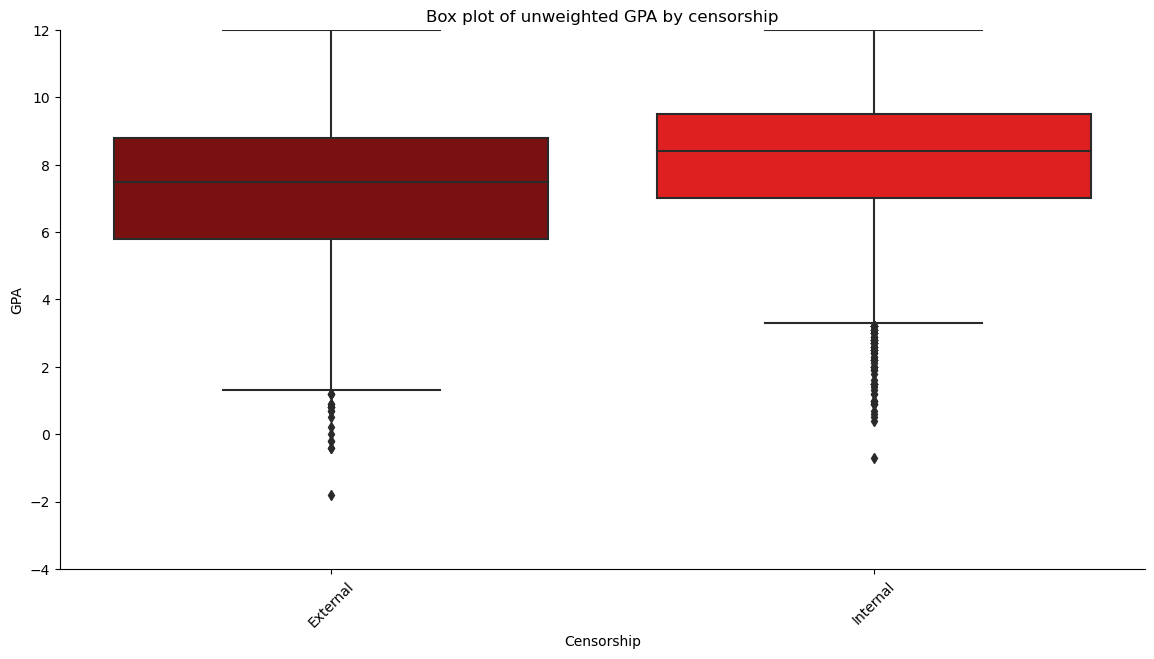

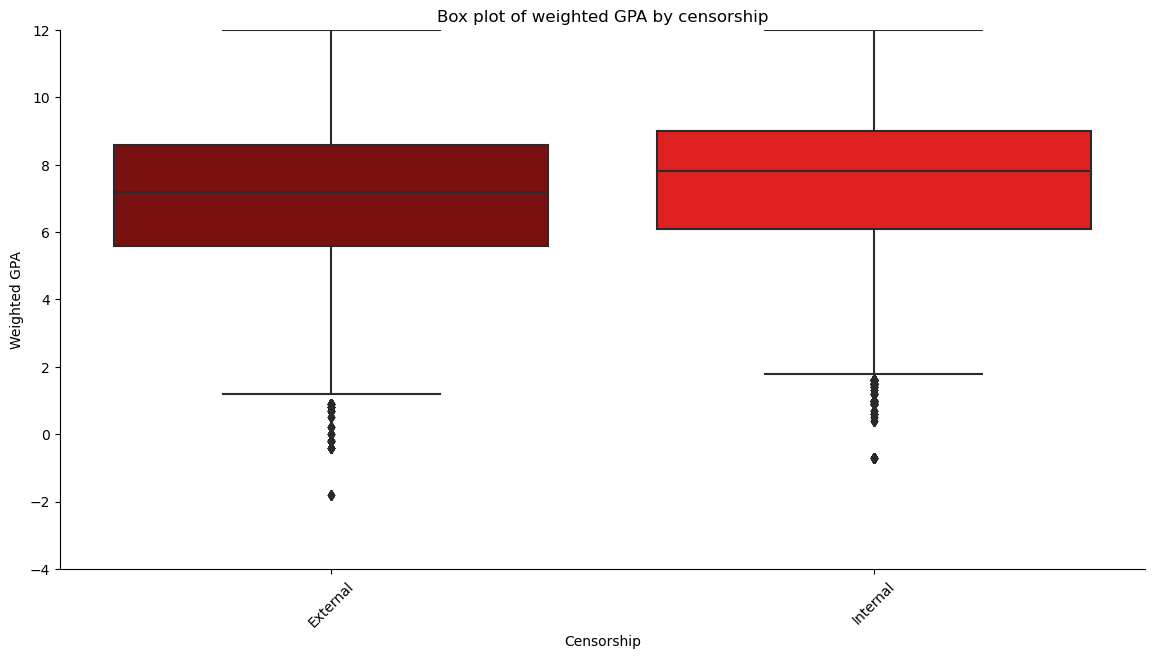

In [137]:
# Ensure necessary columns are numeric
df['Fremmødte'] = pd.to_numeric(df['Fremmødte'], errors='coerce')
df['Eksamensgennemsnit'] = pd.to_numeric(df['Eksamensgennemsnit'], errors='coerce')

# Create a weighted version of 'Eksamensgennemsnit' and expand the dataset
weighted_data = df.loc[df.index.repeat(df['Fremmødte'])].copy()
weighted_data['Weighted Eksamensgennemsnit'] = weighted_data['Eksamensgennemsnit']

# Rename 'Ekstern' to 'External' and 'Intern' to 'Internal'
weighted_data['Bedømmelsesform'] = weighted_data['Bedømmelsesform'].replace({'Ekstern': 'External', 'Intern': 'Internal'})
df['Bedømmelsesform'] = df['Bedømmelsesform'].replace({'Ekstern': 'External', 'Intern': 'Internal'})

# Define the color palette for the box plots
box_color = {'External': 'darkred', 'Internal': 'red'}


# --- Plot Unweighted Box Plot ---
plt.figure(figsize=(14, 7))
sns.boxplot( x='Bedømmelsesform', y='Eksamensgennemsnit', data=df, palette=box_color)
plt.title('Box plot of unweighted GPA by censorship')
plt.xlabel('Censorship')
plt.ylabel('GPA')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('figure3-unweight.png')
plt.show()

# --- Plot Weighted Box Plot ---
plt.figure(figsize=(14, 7))
sns.boxplot(x='Bedømmelsesform', y='Weighted Eksamensgennemsnit', data=weighted_data, palette=custom_palette)
plt.title('Box plot of weighted GPA by censorship')
plt.xlabel('Censorship')
plt.ylabel('Weighted GPA')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('figure3-weight.png')
plt.show()

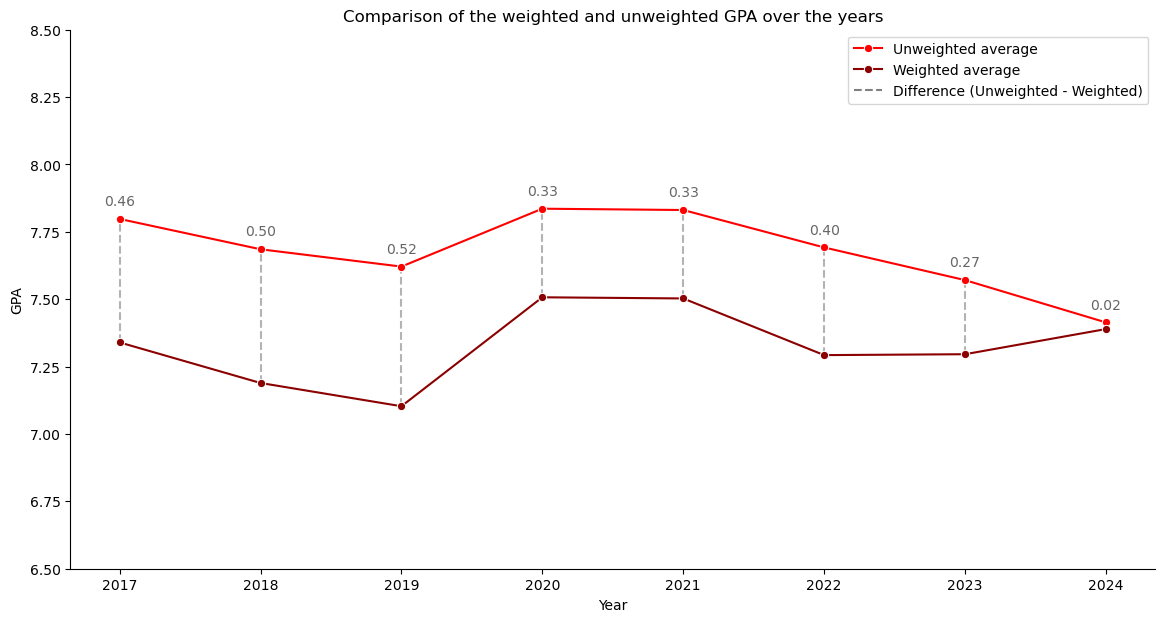

In [100]:
# Ensure necessary columns are numeric
df['Fremmødte'] = pd.to_numeric(df['Fremmødte'], errors='coerce')
df['Eksamensgennemsnit'] = pd.to_numeric(df['Eksamensgennemsnit'], errors='coerce')

# Create a weighted version of 'Eksamensgennemsnit' by expanding the dataset
weighted_data = df.loc[df.index.repeat(df['Fremmødte'])].copy()
weighted_data['Weighted_Eksamensgennemsnit'] = weighted_data['Eksamensgennemsnit']

# Group by 'Year' and calculate the average for the expanded (weighted) dataset
weighted_yearly_avg = weighted_data.groupby('Year')['Weighted_Eksamensgennemsnit'].mean().reset_index()

# Group by 'Year' and calculate the unweighted average from the original data
unweighted_yearly_avg = df.groupby('Year')['Eksamensgennemsnit'].mean().reset_index()

# Calculate the difference between unweighted and weighted averages
difference = unweighted_yearly_avg['Eksamensgennemsnit'] - weighted_yearly_avg['Weighted_Eksamensgennemsnit']

# Plotting both weighted and unweighted Eksamensgennemsnit over the years
plt.figure(figsize=(14, 7))

# Plot unweighted average
sns.lineplot(x='Year', y='Eksamensgennemsnit', data=unweighted_yearly_avg, marker='o', label='Unweighted average', color='red', zorder=2)

# Plot weighted average
sns.lineplot(x='Year', y='Weighted_Eksamensgennemsnit', data=weighted_yearly_avg, marker='o', label='Weighted average', color='darkred', zorder=2)

# Plot the difference as vertical lines and add annotations
for i in range(len(unweighted_yearly_avg)):
    plt.vlines(x=unweighted_yearly_avg['Year'][i], ymin=weighted_yearly_avg['Weighted_Eksamensgennemsnit'][i], ymax=unweighted_yearly_avg['Eksamensgennemsnit'][i], color='0.7', linestyle='--', zorder=1)
    plt.text(unweighted_yearly_avg['Year'][i], unweighted_yearly_avg['Eksamensgennemsnit'][i] + 0.05, f"{difference[i]:.2f}", color='0.4', ha='center')

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Create a custom legend entry for the difference lines
plt.plot([], [], color='0.5', linestyle='--', label='Difference (Unweighted - Weighted)')

# Customize the plot
plt.title('Comparison of the weighted and unweighted GPA over the years')
plt.xlabel('Year')
plt.ylabel('GPA')
plt.ylim(6.5, 8.5)  # Set y-axis limits to reflect the expected grade range (0-12)
plt.legend()  # Show legend to differentiate between the lines

# Save and show the plot
plt.savefig('figure4.png')
plt.show()

In [ ]:
# Ensure necessary columns are numeric
df['Fremmødte'] = pd.to_numeric(df['Fremmødte'], errors='coerce')
df['Eksamensgennemsnit'] = pd.to_numeric(df['Eksamensgennemsnit'], errors='coerce')

# Create a weighted version of 'Eksamensgennemsnit' by expanding the dataset
weighted_data = df.loc[df.index.repeat(df['Fremmødte'])].copy()
weighted_data['Weighted_Eksamensgennemsnit'] = weighted_data['Eksamensgennemsnit']

# Group by 'Institut' and calculate the average for the expanded (weighted) dataset
weighted_institut_avg = weighted_data.groupby('Institut')['Weighted_Eksamensgennemsnit'].mean().reset_index()

# Calculate the overall average of Weighted_Eksamensgennemsnit across all Instituts
overall_avg = weighted_institut_avg['Weighted_Eksamensgennemsnit'].mean()

# Set thresholds for coloring based on 15% above and below the overall average
upper_threshold = overall_avg * 1.15
lower_threshold = overall_avg * 0.85

# Apply coloring based on thresholds
weighted_institut_avg['colors'] = ['red' if x < lower_threshold else 'green' if x > upper_threshold else '0.7' for x in weighted_institut_avg['Weighted_Eksamensgennemsnit']]

# Sort by Weighted Eksamensgennemsnit
df_institut = weighted_institut_avg.sort_values('Weighted_Eksamensgennemsnit')

# Reset index for plotting
df_institut.reset_index(inplace=True)

# Draw the plot
plt.figure(figsize=(8, 14), dpi=80)
plt.scatter(df_institut['Weighted_Eksamensgennemsnit'], df_institut.index, s=450, alpha=0.5, color=df_institut['colors'])

# Add text labels to the points
for x, y, tex in zip(df_institut['Weighted_Eksamensgennemsnit'], df_institut.index, df_institut['Weighted_Eksamensgennemsnit']):
    plt.text(x, y, round(tex, 1), horizontalalignment='center', verticalalignment='center', fontdict={'color': 'white'}, zorder=1)

# Spines
plt.gca().spines["top"].set_alpha(False)
plt.gca().spines["right"].set_alpha(False)
plt.gca().spines["bottom"].set_alpha(0.8)
plt.gca().spines["left"].set_alpha(0.8)

# Customize grid lines
plt.grid(linestyle=('--'), linewidth=1, color='0.8', alpha=0.5, zorder=0)

# Set y-ticks and labels
plt.yticks(df_institut.index, df_institut['Institut'])
plt.xlabel('Weighted GPA')
plt.xlim(min(df_institut['Weighted_Eksamensgennemsnit']) - 1, max(df_institut['Weighted_Eksamensgennemsnit']) + 1)

# Ensure scatter points and labels are on top of the grid
plt.scatter(df_institut['Weighted_Eksamensgennemsnit'], df_institut.index, s=450, alpha=0.5, color=df_institut['colors'], zorder=3)
for x, y, tex in zip(df_institut['Weighted_Eksamensgennemsnit'], df_institut.index, df_institut['Weighted_Eksamensgennemsnit']):
    plt.text(x, y, round(tex, 1), horizontalalignment='center', verticalalignment='center', fontdict={'color': 'white'}, zorder=4)

# Save and show
plt.savefig('figure5.png')
plt.show()